In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import LatticeDefinitions as ld
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSDump as LD
import scipy as sc
#from skimage.morphology import skeletonize, thin, medial_axis
import os
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.cluster.vq import kmeans,vq
from PIL import Image

Estimating the triple line energy using curve fitting. 
In theory the potential energy enclosed in a cylinder should follow the following equation 
$P(r) = \pi h P_{volume}r^2 + \left<w\right> \left< \gamma \right> r + f(r)$ 

In [2]:
def CylinderVolume(h, R)->float:
    return np.pi*h*R**2
def Tanh(r,a, b,c):
    return a*np.tanh(b*r)+c
def GammaR(r, a,b,c):
    return sc.stats.gamma.pdf(r,a,b,c)
def Reciprocal(r,a,b):
    return a/(r+b)-a/b
def FitFunction(r,a,b,c)->float:
    return a*np.tanh(r*b)+c*r
def FitExcess(r,a,b):
    return a*np.log(np.abs(r+1))+b*r
def PowerRule(r, a,b,c):
    return a*r**b+c
def ProportionalRule(r,m):
    return m*r
def LinearRule(r,m,c):
    return r*m+c 
def Quadratic(r,a,b,c):
    return a*r**2+b*r+c
def TQuadratic(r,b,c):
    return A*r**2+b*r+c
def DiffPowerRule(r,a,b):
    return b*a*r**(a-1)
def AsymptoticLinear(r,a,b):
    return a*r - b*np.log(r+b/a) + b*np.log(b/a)
def DiffAL(r,a,b):
    return a -b/(r+b/a)
def Rational(r,a,b,c):
    return (a*r**3+b)/(r**2+c)


In [ ]:
#strDumpFile = '../../PythonLAMMPS/VolumeTest/dump.eam'
#strDumpFile = '../data/dump.eam'
strDumpFile = '/home/paul/csf3_scratch/TripleLines/2Axis111/data5/dump.eam5'
a1=4.05
a2= np.sqrt(3)*4.05
strPMFile = strDumpFile + 'PM'
objData= LD.LAMMPSData(strPMFile,1)
objProcess = objData.GetTimeStepByIndex(-1)
objProcess.CategoriseAtoms()
h = objProcess.CellHeight
objProcess.FindTripleLines(2*a2,3*a2,3)
objProcess.MergePeriodicTripleLines(2*a2)
objProcess.MakeGrainBoundaries()

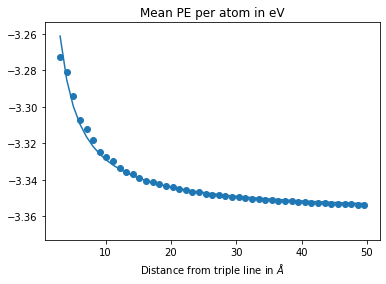

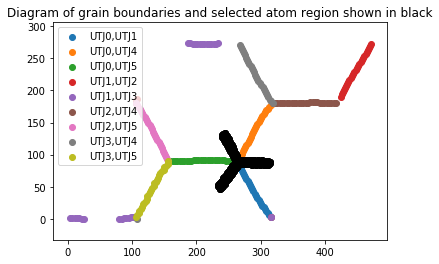

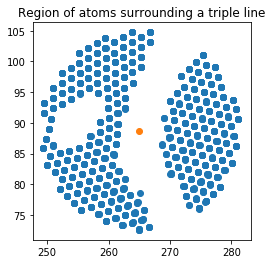

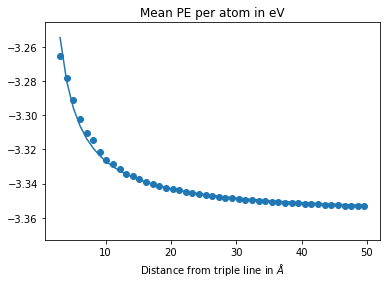

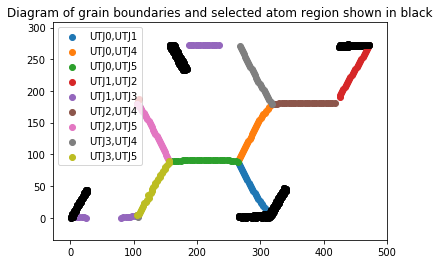

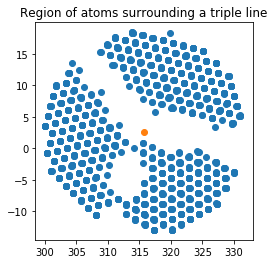

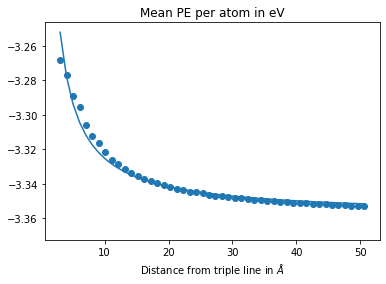

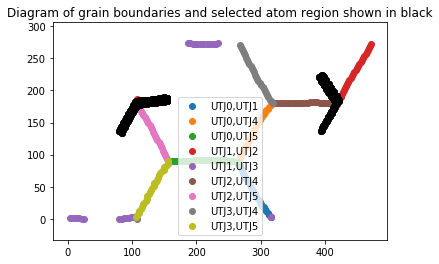

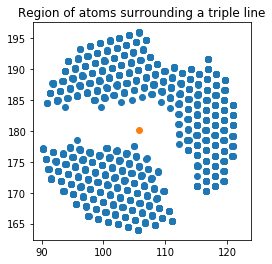

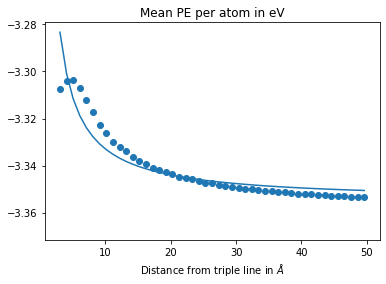

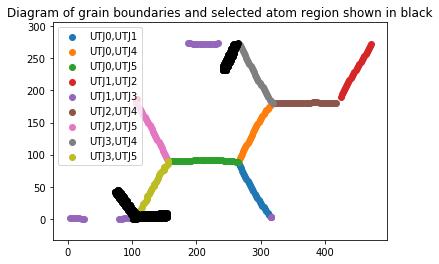

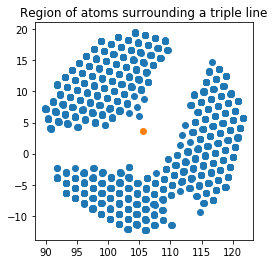

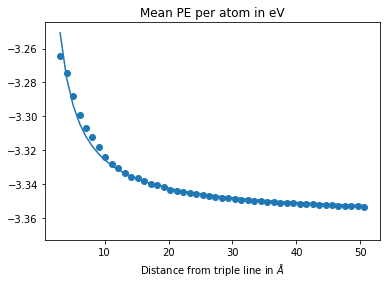

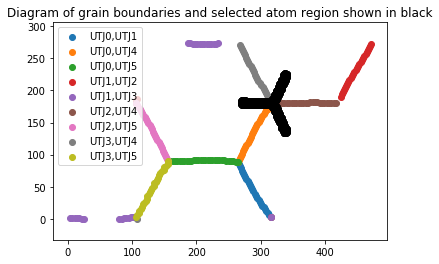

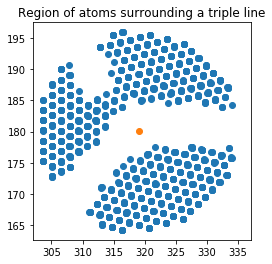

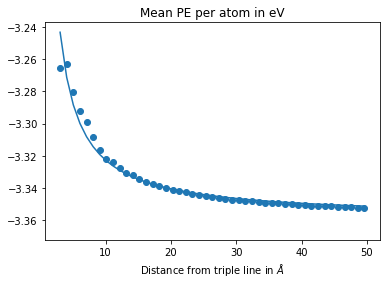

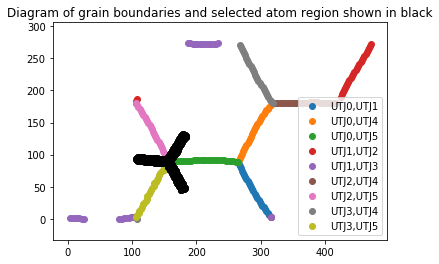

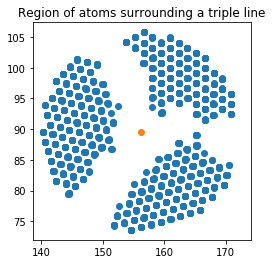

In [8]:
for j in objProcess.GetUniqueTripleLineIDs():
    strTripleLineID = j
    lstFit = []
    lstNumberOfAtoms = []
    lstNewValues = []
    lstRSquared = []
    lstFitR = []
    lstFit2 =[]
    lstRR = []
    lstRlog = []
    lstVlog = []
    lstR, lstV,lstI = objProcess.FindThreeGrainStrips(strTripleLineID,a2,a1/4, 'mean')
    #intStart = len(lstV)-np.argmax(lstV[-1:0:-1])-1
    popt, poptv = sc.optimize.curve_fit(Reciprocal, lstR,lstV)
    for j in lstR:
        lstFitR.append(Reciprocal(j, *popt))
    plt.scatter(lstR,lstV)
    plt.plot(lstR, lstFitR)
    plt.title('Mean PE per atom in eV')
    plt.xlabel('Distance from triple line in $\AA$')
    plt.show()
    plt.axis('equal')
    for j in objProcess.GetUniqueGrainBoundaryIDs():
        arrUniqueGBPoints = objProcess.MoveToSimulationCell(objProcess.GetUniqueGrainBoundaries(j).GetPoints(a2/2))
        plt.scatter(arrUniqueGBPoints[:,0], arrUniqueGBPoints[:,1])
    plt.legend(objProcess.GetUniqueGrainBoundaryIDs())
    plt.scatter(objProcess.GetAtomsByID(lstI)[:,1],objProcess.GetAtomsByID(lstI)[:,2], c='black')
    plt.title('Diagram of grain boundaries and selected atom region shown in black')
    plt.show()
    plt.axis('square')

    arrPoints = objProcess.FindValuesInCylinder(objProcess.GetLatticeAtoms()[:,0:4], 
                                                objProcess.GetUniqueTripleLines(strTripleLineID).GetCentre()
                                                , 4*a1,h,[1,2,3])
    arrMovedPoints = objProcess.PeriodicShiftAllCloser(objProcess.GetUniqueTripleLines(strTripleLineID).GetCentre(), arrPoints)
    plt.scatter(arrMovedPoints[:,0],arrMovedPoints[:,1])
    plt.scatter(objProcess.GetUniqueTripleLines(strTripleLineID).GetCentre()[0],
    objProcess.GetUniqueTripleLines(strTripleLineID).GetCentre()[1])
    plt.axis('square')
    plt.title('Region of atoms surrounding a triple line')
    plt.show()





In [ ]:
plt.scatter(arrMovedPoints[:,0], arrMovedPoints[:,1])
ptMean = np.mean(arrMovedPoints, axis=0)
hull = sc.spatial.ConvexHull(arrMovedPoints[:,0:2])
plt.axis('square')
plt.plot(arrMovedPoints[hull.vertices,0], arrMovedPoints[hull.vertices,1], 'r--', lw=2)
plt.plot(arrMovedPoints[hull.vertices[0],0], arrMovedPoints[hull.vertices[0],1], 'ro')
#plt.quiver(ptMean[0],ptMean[1],FirstDirection[0],FirstDirection[1], scale=5)
arrMeanPoint= np.mean(arrMovedPoints[hull.vertices],axis=0)
for j in range(len(hull.vertices)):
    print(np.linalg.norm(arrMovedPoints[hull.vertices[np.mod(j+1,len(hull.vertices))]]-arrMovedPoints[hull.vertices[j]]))
plt.scatter(arrMeanPoint[0], arrMeanPoint[1])
plt.show()

In [ ]:
n=2
CellArray = plt.imread('/home/paul/csf3_scratch/TripleLines/data17/dump.eam17PM.png')
#CellArray = CellArray[CellArray.any() !=1.0]
CellArray0 = np.copy(CellArray[:,:,0])
arrPoints = np.where(CellArray0 !=1)
xmin = min(arrPoints[0])
xmax = max(arrPoints[0])
ymin = min(arrPoints[1])
ymax = max(arrPoints[1])
CellArray = CellArray[xmin:xmax,ymin:ymax,:]
fltSize = np.shape(CellArray)[1]
CellArray = rescale(CellArray, objProcess.GetBoundingBox()[0]/fltSize)
CellArray = np.flip(CellArray[:,:,:], axis=0)
#plt.matshow(CellArray[:,:,:], origin = 'lower')
# for k in objProcess.GetGrainBoundaryIDs():
#     for j in objProcess.GetGrainBoundaries(k).GetPoints(10):
#          CellArray[np.round(j[1]).astype('int')-n:np.round(j[1]).astype('int')+n, 
#                   np.round(j[0]).astype('int')-n:np.round(j[0]).astype('int')+n,0] =1
for j in objProcess.GetTripleLineIDs():
    CellArray[np.round(objProcess.GetTripleLines(j).GetCentre()[1]).astype('int')
              -n:np.round(objProcess.GetTripleLines(j).GetCentre()[1]).astype('int')
              +n,np.round(objProcess.GetTripleLines(j).GetCentre()[0]).astype('int')
              -n:np.round(objProcess.GetTripleLines(j).GetCentre()[0]).astype('int')+n,
              0] =1
    
plt.matshow(CellArray[:,:,:], origin = 'lower')

In [ ]:
arrCentre = objProcess.GetTripleLines(4)
arrLength = objProcess.GetTripleLines(7)-objProcess.GetTripleLines(4)
arrWidth = 5*a1*np.cross(gf.NormaliseVector(arrLength), np.array([0,0,1]))
lstIDs = objProcess.FindValuesInBox(objProcess.GetNonLatticeAtoms(), arrCentre,arrLength, arrWidth,
                        objProcess.CellHeight*np.array([0,0,1]), [0]) 

arrPoints = objProcess.PeriodicShiftAllCloser(arrCentre,objProcess.GetAtomsByID(lstIDs)[:,1:4])
plt.scatter(arrPoints[:,0], arrPoints[:,1])

In [ ]:
def CubicFitX(x, a2,a3):
    x0 = objProcess.GetTripleLines(5)[0]
    x1 = objProcess.GetTripleLines(1)[0]
    return x0 + (x1-x0-a2-a3)*x + a2*x**2+a3*x**3 
def CubicFitY(x, a2,a3):
    x0 = objProcess.GetTripleLines(5)[1]
    x1 = objProcess.GetTripleLines(1)[1]
    return x0 + (x1-x0-a2-a3)*x + a2*x**2+a3*x**3 
def SampleFunction(Points: np.array):
    t =np.linspace(0,1,len(Points))
    #Points = gf.SortInDistanceOrder(Points)
    xFit = sc.optimize.curve_fit(CubicFitX,t,Points[:,0])[0] 
    yFit = sc.optimize.curve_fit(CubicFitY,t,Points[:,1])[0]
    arrFitX = np.zeros([4])
    arrFitY = np.zeros([4])
    arrFitX[0] = objProcess.GetTripleLines(5)[0]
    arrFitX[1] = objProcess.GetTripleLines(1)[0] - objProcess.GetTripleLines(5)[0] - xFit[0]- xFit[1]
    arrFitY[0] = objProcess.GetTripleLines(5)[1]
    arrFitY[1] = objProcess.GetTripleLines(1)[1] - objProcess.GetTripleLines(5)[1] - yFit[0]- yFit[1]
    return arrFitX,arrFitY
xArr, yArr = SampleFunction(arrPoints)

def Curve(xin, yin, tval):
    arrTValues = np.ones([len(xin)])
    for j in range(len(arrTValues)):
        arrTValues[j] = tval**j
    return np.array([np.dot(arrTValues, xin), np.dot(arrTValues, yin)])

Curve(xArr,yArr,0.7)
arrPlotPoints = np.zeros([len(t)+1,2])
t =np.linspace(0,1,len(arrPoints))
counter = 0
for j in t:
    arrPlotPoints[counter] = Curve(xArr,yArr,j)
    counter +=1
plt.plot(arrPlotPoints[:,0],arrPlotPoints[:,1])

In [ ]:
class GrainBoundaryCurve(object):
    def __init__(self,arrTwoTripleLines: np.array, arrLatticePoints2D, lstTJIDs):
        arrPoints = gf.SortInDistanceOrder(arrLatticePoints2D)[0]
        self.__TripleLines = dict()
        self.__TripleLineIDs = lstTJIDs
        self.__XFit = np.zeros([4])
        self.__YFit = np.zeros([4])
        for j in range(2):
            self.__TripleLines[str(lstTJIDs[j])] =arrTwoTripleLines[j]
        self.CreateCurve(arrPoints)
    def GetTripleLine(self,strKey)->np.array:
        return self.__TripleLines[str(strKey)]
    def GetTripleLineNumbers(self)->list:
        return self.__TripleLineIDs
    def __CubicFitX(self,x, a2,a3):
        x0 = self.GetTripleLine(self.__TripleLineIDs[0])[0]
        x1 = self.GetTripleLine(self.__TripleLineIDs[1])[0]
        return x0 + (x1-x0-a2-a3)*x + a2*x**2+a3*x**3 
    def __CubicFitY(self,y, a2,a3):
        y0 = self.GetTripleLine(self.__TripleLineIDs[0])[1]
        y1 = self.GetTripleLine(self.__TripleLineIDs[1])[1]
        return y0 + (y1-y0-a2-a3)*y + a2*y**2+a3*y**3 
    def CreateCurve(self, arrPoints: np.array):
        t =np.linspace(0,1,len(arrPoints))
        self.__XFit[2:4] = sc.optimize.curve_fit(self.__CubicFitX,t,arrPoints[:,0])[0] 
        self.__YFit[2:4] = sc.optimize.curve_fit(self.__CubicFitY,t,arrPoints[:,1])[0]
        self.__XFit[0] = self.GetTripleLine(self.__TripleLineIDs[0])[0]
        self.__YFit[0] = self.GetTripleLine(self.__TripleLineIDs[0])[1]
        self.__XFit[1] = self.GetTripleLine(self.__TripleLineIDs[1])[0] -self.__XFit[0] -self.__XFit[2]
        -self.__XFit[3]
        self.__YFit[1] = self.GetTripleLine(self.__TripleLineIDs[1])[1] -self.__YFit[0] -self.__YFit[2]
        -self.__YFit[3]
        #return self.__XFit, self.__YFit
    def Curve(self,fltTValue:float)->np.array:
        arrTValues = np.ones([4])
        for j in range(len(arrTValues)):
            arrTValues[j] = fltTValue**j
        return np.array([np.dot(arrTValues, self.__XFit), np.dot(arrTValues, self.__YFit)])
    def PlotPoints(self, intNumberOfPoints)->np.array:
        t = np.linspace(0,1, intNumberOfPoints)
        arrPoints = np.zeros([intNumberOfPoints,2])
        counter = 0
        for fltTValue in t:
            arrPoints[counter] = self.Curve(fltTValue)
            counter +=1
        #return zip(*arrPoints)
        return arrPoints       
    


In [ ]:
arrStart = objProcess.GetUniqueTripleLines(0)
arrSecondTriple = objProcess.PeriodicShiftCloser(arrStart,objProcess.GetUniqueTripleLines(1))
arrLength = arrSecondTriple-arrStart
arrLength[2] = 12.15
arrWidth = 5*a1*np.cross(gf.NormaliseVector(arrLength), np.array([0,0,1]))
arrPoints = objProcess.FindValuesInBox(objProcess.GetNonLatticeAtoms()[:,0:4], arrStart,arrLength,arrWidth,
                        objProcess.CellHeight*np.array([0,0,1]), [1,2,3]) 

arrPoints = objProcess.PeriodicShiftAllCloser(arrStart,arrPoints)
plt.scatter(arrPoints[:,0],arrPoints[:,1])
#plt.axis('square')
objGB = GrainBoundaryCurve(np.array([arrStart, arrSecondTriple]),arrPoints[:,0:2],
             [0,1])
print(objProcess.GetAdjacentTripleLines(0))
print(objGB.PlotPoints(20)[:,0],objGB.PlotPoints(20)[:,1])
plt.scatter(arrStart[0], arrStart[1])
plt.scatter(arrSecondTriple[0], arrSecondTriple[1])
plt.show()
print(objGB.GetTripleLine(1))

In [ ]:
def GeneralQuadratic(X: np.array, a1, a2, b1,b2,c1)->float:
    x,y =X
    return a1*x + b1*y+ a2*x**2+b2*y**2 + c1*x*y

In [ ]:
arrStart = objProcess.GetUniqueTripleLines(0)
arrSecondTriple = objProcess.PeriodicShiftCloser(arrStart,objProcess.GetUniqueTripleLines(1))
arrLength = arrSecondTriple-arrStart
arrLength[2] = 12.15
arrWidth = 10*a1*np.cross(gf.NormaliseVector(arrLength), np.array([0,0,1]))
arrPoints = objProcess.FindValuesInBox(objProcess.GetNonLatticeAtoms()[:,0:4], arrStart+0.05*arrLength,0.9*arrLength,arrWidth,
                        objProcess.CellHeight*np.array([0,0,1]), [1,2,3]) 
arrPoints = objProcess.PeriodicShiftAllCloser(arrStart,arrPoints)
arrPointsM = arrPoints - arrStart
arrLinearVector = arrSecondTriple[0:2]- arrStart[0:2]
arrUnitVector = gf.NormaliseVector(arrLinearVector)
arrProjection = np.zeros([len(arrPointsM),2])
for pos,j in enumerate(arrPointsM[:,0:2]):
    arrCross = np.cross(arrUnitVector,j)
    arrProjection[pos,1] = arrCross
    arrProjection[pos,0] = np.dot(j-arrCross,arrUnitVector)
#print(arrProjection)
arrProjection = arrProjection[np.where((arrProjection[:,0] >=0) 
                              & (arrProjection[:,0] <= np.linalg.norm(arrLinearVector)))]
plt.scatter(arrProjection[:,0],arrProjection[:,1])
plt.show()

In [ ]:
def GrainCurve(t, a2,a3):
    return (np.linalg.norm(arrLinearVector,axis=0)-a2-a3)*t + a2*t**2 + a3*t**3
def Length(t):
    return np.sqrt(t**2+(GrainCurve(t,*popt))**2)
popt, popv = sc.optimize.curve_fit(GrainCurve, arrProjection[0], arrProjection[1])
t =np.linspace(0,1,10)
arrPointsOut = np.zeros([len(t),2])
counter = 0
for tval in t:
    arrPointsOut[counter]= arrStart[0:2] + GrainCurve(tval,*popt)*np.cross(arrUnitVector, np.array([0,1])) 
    + tval*arrLinearVector
    counter +=1 
plt.scatter(arrPointsOut[:,0], arrPointsOut[:,1])
#plt.plot(t,GrainCurve(t,*popt))
print(Length(1), popt)

In [ ]:
class TripleLine(object):
    def _init__(self,intID: int,arrCentre: np.array, arrDirection: np.array):
        self.__Centre = arrCentre
        self.__Direction = arrDirection
        self.__ID = intID
        self.__EquivalentTripleLines = []
        self.__AdjacentTripleLines = []
    def GetCentre(self)->np.array:
        return self.__Centre
    def SetCentre(self, arrCentre: np.array):
        self.__Centre = arrCentre
    def SetEquivalentTripleLines(self, lstIDs: list):
        self.__EquivalentTripleLines = lstIDs
    def GetEquivalentTripeLines(self)->list:
        return self.__EquivalentTripleLines
    def SetAdjacentTripleLines(self, lstIDs: list):
        self.__AdjacentTripleLines = lstIDs
    def GetAdjacentTripleLines(self, lstIDs: list):
        return self.__AdjacentTripleLines
    

In [ ]:
lstTotalPE = []
lstExcess = []
lstFitExcess= []
intPE = objProcess.GetColumnNames().index('c_pe1')
for counter, r in enumerate(lstR): 
    values = objProcess.FindValuesInCylinder(objProcess.GetAtomData()[:,0:4], 
                                             objProcess.GetTripleLines(intTripleLine), r,h,intPE)
    lstTotalPE.append(np.mean(values))
    lstExcess.append(np.sum(values)- lstV[counter]*len(values))
popt, poptv = sc.optimize.curve_fit(LinearRule, lstR,lstExcess)
for r in lstR:
    lstFitExcess.append(LinearRule(r, *popt))
plt.scatter(lstR,lstTotalPE)
plt.show()
plt.scatter(lstR, lstExcess)
plt.plot(lstR,lstFitExcess)
plt.show()
print(*popt)

In [ ]:
arrPE = np.unique(np.round(objProcess.GetNonLatticeAtoms()[:,7],5))
plt.hist(arrPE, bins=50)

In [ ]:
lstAG = []
for i in range(1,91):
    lstAG.append(gf.AngleGenerator(i,15,180))
print(np.sort(lstAG, axis=1))

In [ ]:
def AngleGenerator(intJobArray: int, fltIncrement: float, fltSymmetry: float):
    intN = int(fltSymmetry/fltIncrement -1)
    lstOfValues = []
    arrOfValues = np.zeros([intN*(intN-1),2])
    for i in range(intN):
        lstOfValues.append(fltIncrement*(i+1))
    counter = 0
    for j in lstOfValues:
        for k in lstOfValues:
            if j!=k:
                arrOfValues[counter,0] = j
                arrOfValues[counter,1] = k
                counter +=1
    return arrOfValues[intJobArray, 0],arrOfValues[intJobArray, 1]

AngleGenerator(list(range(20)),15,90)


In [ ]:
def PotentialEnergyInVolume(arrTriplePoint: np.array, fltRadius:float, fltHeight :float)->float:
    arrTriplePoints = objProcess.PeriodicEquivalents(arrTriplePoint)
    lstPoints = []
    for j in arrTriplePoints:
        lstPoints.extend(np.where(np.linalg.norm(objProcess.GetAtomData()[:,1:3]-j[0:2],axis=1) 
                         <fltRadius)[0])
    lstPoints = list(np.unique(lstPoints))
    return (np.sum(objProcess.GetAtomData()[lstPoints][:,7])/CylinderVolume(fltHeight,fltRadius)) 

In [ ]:
def PotentialEnergyPerAtom(arrTriplePoint: np.array, fltRadius:float, fltHeight :float)->float:
    arrTriplePoints = objProcess.PeriodicEquivalents(arrTriplePoint)
    lstPoints = []
    for j in arrTriplePoints:
        lstPoints.extend(np.where(np.linalg.norm(objProcess.GetAtomData()[:,1:3]-j[0:2],axis=1) 
                         <fltRadius)[0])
    lstPoints = list(np.unique(lstPoints))
    return (np.sum(objProcess.GetAtomData()[lstPoints][:,7])/len(lstPoints)) 

In [ ]:
def FormPotentialListVolume(intLength: int, flta: float, flth: float, arrPoint: np.array)->list:
    Radii = np.linspace(flta/(np.sqrt(2)),0.5*intLength*flta/(np.sqrt(2)),intLength)
    lstPotentialValues = []
    for r in Radii:
        lstPotentialValues.append(PotentialEnergyInVolume(arrPoint, r,flth))
    return Radii,lstPotentialValues

In [ ]:
def FormPotentialListAtom(intLength: int, flta: float, flth: float, arrPoint: np.array)->list:
    Radii = np.linspace(flta/(np.sqrt(2)),0.5*intLength*flta/(np.sqrt(2)),intLength)
    lstPotentialValues = []
    for r in Radii:
        lstPotentialValues.append(PotentialEnergyPerAtom(arrPoint, r,flth))
    return Radii,lstPotentialValues

In [ ]:
fig,axs = plt.subplots(len(arrTriplePoints),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
for pos,j in enumerate(arrTriplePoints):
    axs[2*pos].scatter(*FormPotentialListVolume(25, a1, 2*a1, j))
    axs[2*pos+1].scatter(*FormPotentialListAtom(25, a1, 2*a1, j))
    axs[2*pos].set_title('Triple line mean position is '+ str(np.round(j)))
    axs[2*pos+1].set_title('Triple line mean position is '+ str(np.round(j)))
    axs[2*pos].set_ylabel('Potential Energy per Unit Volume in eV per $\AA^3$' )
    axs[2*pos].set_xlabel('Radial distance from triple line axis in $\AA$')
    axs[2*pos+1].set_ylabel('Potential Energy per atom in $eV$' )
    axs[2*pos+1].set_xlabel('Radial distance from triple line axis in $\AA$')

In [ ]:
-3.36*4/(4.05**3) #FCC cell has 4 atoms in a perfect lattice each atom is approx -3.36 eV 
len(arrTriplePoints)

In [ ]:
arrTriplePoints = objProcess.FindTriplePoints(4.05,4.05, True)
arrGrainBoundaries = objProcess.GetGrainBoundaries()
print(arrTriplePoints)

In [ ]:
def GetGrainBoundarySegments(objGB, fltWidth: float):
    #arrPoints = gf.SortInDistanceOrder(arr2DPoints[:,0:2])[0]
    lstPositions =[]
    lstTotalPE = []
    lstTotalPositions = []
    for j in range(0,objGB.GetNumberOfPoints()-1):
        arrVector = objGB.GetVector(j)
        arrAcross = fltWidth*objGB.GetAcrossVector(j)
        arrCentre3d = objGB.GetCentre(j) 
        arrCentre3d[2] = 4.05
        lstPositions = objProcess.FindBoxAtoms(arrCentre3d[0:2],arrVector[0:2],arrAcross[0:2])
      #  lstPositions = objProcess.FindCylindricalAtoms(np.array([arrPoints[j][0],arrPoints[j][1],0]), fltWidth)
        lstPositions = list(np.unique(lstPositions))
        lstTotalPE.append(np.sum(objProcess.GetRows(lstPositions)[:,intPE]))
        lstTotalPositions.extend(objProcess.GetRows(lstPositions)[:,1:3])
    lstTotalPositions = np.array(lstTotalPositions)
    return lstTotalPE, lstTotalPositions

In [ ]:
arrGrainBoundaries = objProcess.GetGrainBoundaries()
fig,axs = plt.subplots(len(arrGrainBoundaries),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
lstPE = []
lstPositions = []
fltWidth= 4*a1
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 2: 
        lstLengths = []
        objGB = gl.GrainBoundary(arrGrainBoundaries[j])
        
        lstPE, lstPositions = GetGrainBoundarySegments(objGB, fltWidth)
        for k in range(len(lstPE)):
            lstLengths.append(objGB.GetAccumulativeLength(k))
            lstPE[k] = lstPE[k]/(objGB.GetSegmentLength(k)*fltWidth*h)
        axs[2*j].set(xlim=(0, objProcess.GetCellVectors()[0][0]+objProcess.GetCellVectors()[1][0]),
                     ylim = (0,objProcess.GetCellVectors()[1][1]))
        axs[2*j].axis('equal')
        axs[2*j].scatter(lstPositions[:,0],lstPositions[:,1])
        axs[2*j].scatter(objGB.GetPoints()[:,0],objGB.GetPoints()[:,1])
        axs[2*j+1].scatter(lstLengths,lstPE)
        axs[2*j].set_title('Atomic Positions for Grain Boundary '+ str(np.round(j)))
        axs[2*j+1].set_title('Potential Energy in $eV$ for Grain Boundary '+ str(np.round(j)))
        axs[2*j].set_ylabel('Position in $\AA$' )
        axs[2*j].set_xlabel('Position in $\AA$')
        axs[2*j+1].set_ylabel('Potential Energy per atom in eV$' )
        axs[2*j+1].set_xlabel('Approximate Position Number on Grain Boundary')

In [ ]:
fig,axs = plt.subplots(len(arrGrainBoundaries),1, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 1:
        objGB2 = gl.GrainBoundary(arrGrainBoundaries[j])
        lstPE = []
        lstWidth =[]
        for k in range(2,12):
            lstPE.append(np.mean(GetGrainBoundarySegments(objGB2, k*a1/4)[0]))
            lstWidth.append(k*a1/2) 
            
        axs[j].scatter(lstWidth,lstPE)
        axs[j].set_title('PE per Atom Against Cuboid Width '+ str(np.round(j)))
        axs[j].set_ylabel('PE per Atom in $eV$$' )
        axs[j].set_xlabel('Cuboid Width in $\AA$')
            

In [ ]:
def TurningRegion(arrPoints, arrAcross1,arrAcross2, fltWidth)->list:
    lstIndices = []
    arrUnit1 = gf.NormaliseVector(arrAcross1[0:2])
    arrUnit2 = gf.NormaliseVector(arrAcross2[0:2])
    fltDirection = np.sign(np.cross(arrAcross1, arrAcross2)[2])
    if fltDirection < 0: 
        lstIndices.extend(np.where((np.dot(arrPoints,arrUnit1) > 0) & (np.dot(arrPoints,arrUnit1) < fltWidth)
                             & (np.dot(arrPoints,arrUnit2) > 0) & (np.dot(arrPoints,arrUnit2) < fltWidth))[0])
    elif fltDirection > 0:
        lstIndices.extend(np.where((np.dot(arrPoints,arrUnit1) < 0) & (np.dot(arrPoints,arrUnit1) > -fltWidth)
                                  & (np.dot(arrPoints,arrUnit2) < 0) & (np.dot(arrPoints,arrUnit2) > -fltWidth))[0])
    return list(lstIndices)

In [ ]:
objGB1 = gl.GrainBoundary(arrGrainBoundaries[5])
lstPoints = TurningRegion(objProcess.GetAtomData()[:,1:3]-objGB1.GetPoints(6)[0:2], objGB1.GetVector(0), 
              objGB1.GetVector(8), 1)
plt.scatter(objProcess.GetRows(lstPoints)[:,1],objProcess.GetRows(lstPoints)[:,2]);

In [ ]:
np.where(np.dot(objProcess.GetAtomData()[:,1:3]-objGB1.GetPoints(1)[0:2],
                gf.NormaliseVector(objGB1.GetVector(1))[0:2])<0)

In [ ]:
np.strip('TJ10',2)


In [ ]:
objGB1.GetVector(5)

In [ ]:
def GetGrainBoundary(objGB, fltWidth: float):
    #arrPoints = gf.SortInDistanceOrder(arr2DPoints[:,0:2])[0]
    lstPositions =[]
    lstTotalPE = []
    lstTotalPositions = []
    lstArcs = []
    arrFirstCentre = objGB.GetCentre(0)
    lstArcs.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrFirstCentre[0:2],
                           objGB.GetAcrossVector(0)[0:2], -objGB.GetAcrossVector(0)[0:2], fltWidth))
    lstArcs.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrFirstCentre[0:2],
                           objGB.GetAcrossVector(-1)[0:2], -objGB.GetAcrossVector(-1)[0:2], fltWidth))
    for j in range(0,objGB.GetNumberOfPoints()-1):
        arrVector = objGB.GetVector(j)
        arrAcross = fltWidth*objGB.GetAcrossVector(j)
        arrCentre3d = objGB.GetCentre(j) 
        arrCentre3d[2] = 4.05
        lstPositions.extend(objProcess.FindBoxAtoms(arrCentre3d[0:2],arrVector[0:2],arrAcross[0:2]))
        if j > 1:
            lstPositions.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrCentre3d[0:2],
                           objGB.GetAcrossVector(j)[0:2], objGB.GetAcrossVector(j-1)[0:2], fltWidth))
            lstPositions.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrCentre3d[0:2],
                           -objGB.GetAcrossVector(j)[0:2], -objGB.GetAcrossVector(j-1)[0:2], fltWidth))
      #  lstPositions = objProcess.FindCylindricalAtoms(np.array([arrPoints[j][0],arrPoints[j][1],0]), fltWidth)
        lstPositions = set(np.unique(lstPositions))
        lstPositions.difference(lstArcs)
        lstPositions = list(lstPositions)
        lstTotalPE.append(np.sum(objProcess.GetRows(lstPositions)[:,intPE]))
        lstTotalPositions.extend(objProcess.GetRows(lstPositions)[:,1:3])
    lstTotalPositions = np.array(lstTotalPositions)
    return lstTotalPE, lstTotalPositions

In [ ]:
GetGrainBoundary(objGB2,5)

In [ ]:
objGB2.GetAcrossVector(1)

In [ ]:
arrGrainBoundaries = objProcess.GetGrainBoundaries()
fig,axs = plt.subplots(len(arrGrainBoundaries),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
lstPE = []
lstPositions = []
fltWidth= 2*a1
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 2: 
        lstLengths = []
        objGB = gl.GrainBoundary(arrGrainBoundaries[j])
        
        lstPE, lstPositions = GetGrainBoundary(objGB, fltWidth)
        for k in range(len(lstPE)):
            lstLengths.append(objGB.GetAccumulativeLength(k))
            lstPE[k] = lstPE[k]/(objGB.GetSegmentLength(k)*fltWidth*h)
        axs[2*j].set(xlim=(0, objProcess.GetCellVectors()[0][0]+objProcess.GetCellVectors()[1][0]),
                     ylim = (0,objProcess.GetCellVectors()[1][1]))
        axs[2*j].axis('equal')
        axs[2*j].scatter(lstPositions[:,0],lstPositions[:,1])
        axs[2*j].scatter(objGB.GetPoints()[:,0],objGB.GetPoints()[:,1])
        axs[2*j+1].scatter(lstLengths,lstPE)
        axs[2*j].set_title('Atomic Positions for Grain Boundary '+ str(np.round(j)))
        axs[2*j+1].set_title('Potential Energy in $eV$ for Grain Boundary '+ str(np.round(j)))
        axs[2*j].set_ylabel('Position in $\AA$' )
        axs[2*j].set_xlabel('Position in $\AA$')
        axs[2*j+1].set_ylabel('Potential Energy per atom in eV$' )
        axs[2*j+1].set_xlabel('Approximate Position Number on Grain Boundary')

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
lstP = gf.CylindricalVolume(objProcess.GetAtomData()[:,1:4], arrTriplePoints[10], 15, objProcess.CellHeight)
ax.scatter(objProcess.GetRows(lstP)[:,1], objProcess.GetRows(lstP)[:,2],objProcess.GetRows(lstP)[:,3])

In [ ]:
plt.scatter(objProcess.GetGrainBoundaries(1).GetPoints()[:,0],objProcess.GetGrainBoundaries(1).GetPoints()[:,1])


In [ ]:
def ConvertToImage(vctImageAcross: np.array, vctImageDiagonal: np.array, 
                   arrPoints: np.array, arrMatrix: np.array)->np.array:
    arrNewPoints = np.matmul(arrPoints, arrMatrix)
    arrNewPoints = np.mod(arrNewPoints, np.ones(3))
    arrReturn2DPoints = np.zeros([len(arrNewPoints),2])
    for j, point in enumerate(arrNewPoints):
        arrReturn2DPoints[j] = point[0]*vctImageAcross + point[1]*vctDiagonal
    

In [ ]:
n = 5
intUp, intAcross = np.shape(CellArray)[0:2]
#arrTriplePoints = objProcess.MoveToSimulationCell(arrTriplePoints)
NewTriplePoints = np.matmul(arrTriplePoints, objProcess.GetBasisConversions())
NewTriplePoints = np.mod(NewTriplePoints, np.ones(3))
fltBase = intUp/np.tan(np.pi/3)
vctAcross = np.array([intAcross-fltBase, 0])
vctDiagonal = np.array([fltBase, intUp])
for j in NewTriplePoints:
    arrCurrentPoint = j[0]*vctAcross + j[1]*vctDiagonal
    #arrCurrentPoint[0] = j[0]/np.linalg.norm(objProcess.GetCellVectors()[0])*intDown
    #arrCurrentPoint[1] = (1-j[1]/np.linalg.norm(objProcess.GetCellVectors()[1]))*intDown
    CellArray[arrCurrentPoint[1].astype('int')-n:arrCurrentPoint[1].astype('int')+n, 
              arrCurrentPoint[0].astype('int')-n:arrCurrentPoint[0].astype('int')+n,0] =1
plt.matshow(CellArray, origin = 'lower')

In [ ]:
arrPoint = objProcess.GetTripleLines()[8]
lstIndices = gf.CylindricalVolume(objProcess.GetLatticeAtoms()[:,1:4], arrPoint,2*a1, h )
#lstIndices = objProcess.FindCylindricalAtoms(objProcess.GetOtherAtoms()[:1:4], arrPoint, 2*a1,h)
arrCylinder = objProcess.GetLatticeAtoms()[lstIndices, 1:4]
print(arrPoint)

In [ ]:
plt.scatter(arrCylinder[:,0],arrCylinder[:,1])


In [ ]:
print(arrPoint, np.mean(arrCylinder, axis=0), len(arrCylinder))


In [ ]:
objProcess.GetNumberOfLatticeAtoms()


In [ ]:
for j in range(1,21):
    fltIncrements = 10
    fltSymmetry = 60 
    fltAngle1, fltAngle2 = np.divmod((j-1)*fltIncrements, fltSymmetry-2*fltIncrements)
    fltAngle1 = fltAngle1*fltIncrements+fltIncrements 
    fltAngle2 = np.mod(fltAngle1+fltAngle2, fltSymmetry-fltIncrements)
    print(fltAngle1, fltAngle2+fltIncrements)

In [ ]:
for j in range(1,21):
    print(gf.AngleGenerator(j, 15,90))S
    

(90-30)/15




In [ ]:
np.mod(np.array([[-3,5],[2,2]]), np.array([2,4]))

In [ ]:
arrT = np.array([13,4.05,-21])
str(arrT)